DECLARING NECESSARY LIB

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


SEARCHING FOR P100

In [ ]:
import os
import time
x=!nvidia-smi
count=0
for i in x:
    if "============" in i:
        count+=1
        break
    count+=1
if 'p100' in x[count].lower():
    print("found")
else:
    print(x[count])
    time.sleep(1)
    #os._exit(00)

found


In [ ]:
import tensorflow
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8943380479612246035
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4029220330152765335
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9074535273041382200
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695549568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12550497596693153959
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Declaring the image size and the train, test pat of the dataset

In [ ]:
# Resizinig all the images to (224,224)
IMAGE_SIZE = [224,224]

train_path = '/content/drive/My Drive/Data (2)/new/covid_update/Train'
test_path = '/content/drive/My Drive/Data (2)/new/covid_update/Test'

* Now we need to read all the images from the folder.
* When we'll be reading the data from the folders we also need to make sure that we need to do some **Data Augmentation**.
* The Data Augmentation can be done by using **ImageDataGenerator** library.
* The **ImageDataGenerator** what is does that it applies the Data Augmentation techniques like zooming, scaling, horizontal flipping, vertical flipping, etc.
* **IN THE TEST DATA WE SHOULD NEVER PERFORM DATA AUGMENTATION WE SHOULD ONLY PERFORM SCALING**

In [ ]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# flow_from_directory means i am applying all the train_datagen techniques to all the images
# We need to provide the same traget_size as initialized in the IMAGE_SIZE
# If you have more than two classes we should use class_mode = categorical
# But if we have just two classses we can use class_mode = binary

train_set = train_datagen.flow_from_directory('/content/drive/My Drive/Data (2)/new/covid_update/Train',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode = 'categorical')
# Applying the same techniques on the test dataset

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Data (2)/new/covid_update/Test',
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 453 images belonging to 2 classes.
Found 219 images belonging to 2 classes.


# In this we will be using ResNet-50
* The specialized network was introduced by microsoft
* The ResNet has extremely deep network i.e 152 layers.
* The shallower version (i.e ResNet50) is available

### Why ResNet performs well ?
* Having a regular network which is very deeo actually hurts the performance because of vanishing gradient & exploding gradient.
* In most of the ResNet cases the ResNet will stop improving rather than decreasing the performance.
* If the layer is not useful the L2 Regularization will bring its parameters very close to zero.
* It has moderate efficiency depending on model and has the highest accuracy.
* ResNet allows us to converge more faster


In [ ]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 6s 0us/step


* Now we dont have to train the existing weights we just have to train our last layer.

In [ ]:
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
folder = glob('/content/drive/My Drive/Data (2)/new/covid_update/*')
folder

['/content/drive/My Drive/Data (2)/new/covid_update/Train',
 '/content/drive/My Drive/Data (2)/new/covid_update/Test']

In [ ]:
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folder), activation='softmax')(x)

In [ ]:
model = Model(inputs = resnet.inputs, outputs = prediction)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
15/15 [==============================] - 452s 30s/step - loss: 2.7617 - accuracy: 0.5320 - val_loss: 2.3224 - val_accuracy: 0.4566
Epoch 2/50
15/15 [==============================] - 16s 1s/step - loss: 0.9297 - accuracy: 0.6336 - val_loss: 1.2682 - val_accuracy: 0.5479
Epoch 3/50
15/15 [==============================] - 16s 1s/step - loss: 0.4727 - accuracy: 0.8168 - val_loss: 0.7163 - val_accuracy: 0.6941
Epoch 4/50
15/15 [==============================] - 16s 1s/step - loss: 0.5095 - accuracy: 0.7395 - val_loss: 0.4237 - val_accuracy: 0.8174
Epoch 5/50
15/15 [==============================] - 16s 1s/step - loss: 0.3300 - accuracy: 0.8433 - val_loss: 0.7122 - val_accuracy: 0.7032
Epoch 6/50
15/15 [==============================] - 16s 1s/step - loss: 0.2976 - accuracy: 0.8742 - val_loss: 0.4593 - val_accuracy: 0.7900
Epoch 7/50
15/15 [==============================] - 16s 1s/step - loss: 0.3288 - a

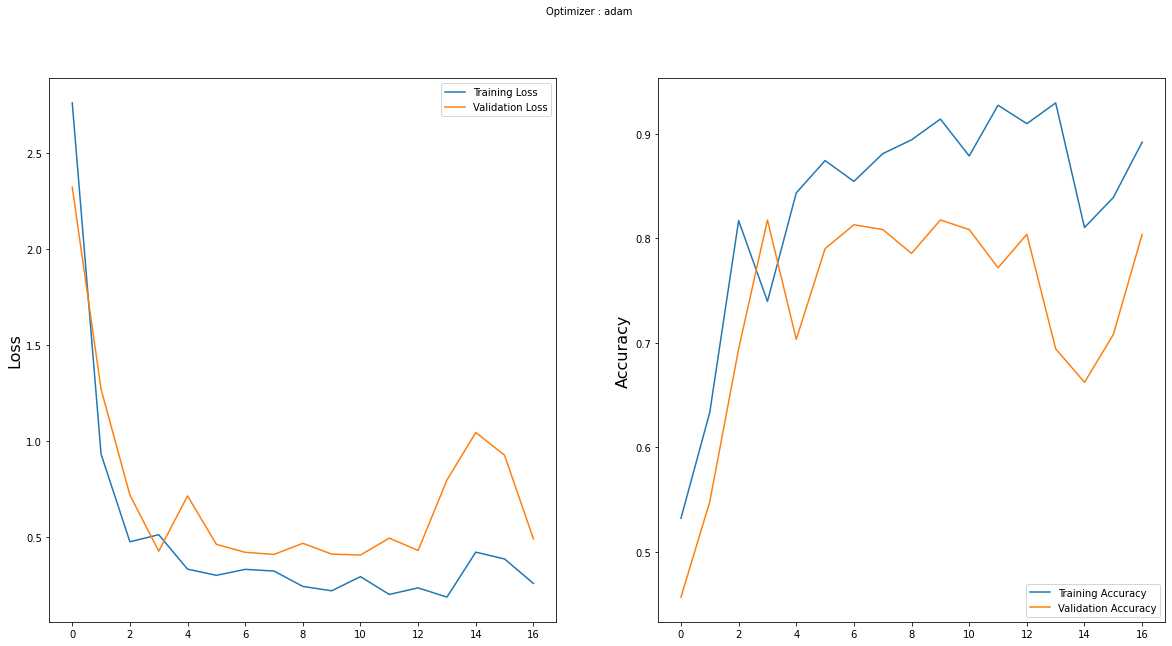

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = model.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[callback])

import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_p=model.predict(test_set,verbose=1,steps=len(test_set))
y_pr=np.argmax(y_p,axis=1)
cm1=confusion_matrix(test_set.classes,y_pr)
total1=sum(sum(cm1))
#from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)
print(classification_report(test_set.classes, y_pr))

7/7 [==============================] - 4s 605ms/step
Accuracy :  0.4931506849315068
Sensitivity :  0.56
Specificity :  0.4369747899159664
              precision    recall  f1-score   support

           0       0.46      0.56      0.50       100
           1       0.54      0.44      0.48       119

    accuracy                           0.49       219
   macro avg       0.50      0.50      0.49       219
weighted avg       0.50      0.49      0.49       219



For InceptionV3 with optimiser adam

87916544/87910968 [==============================] - 4s 0us/step
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________

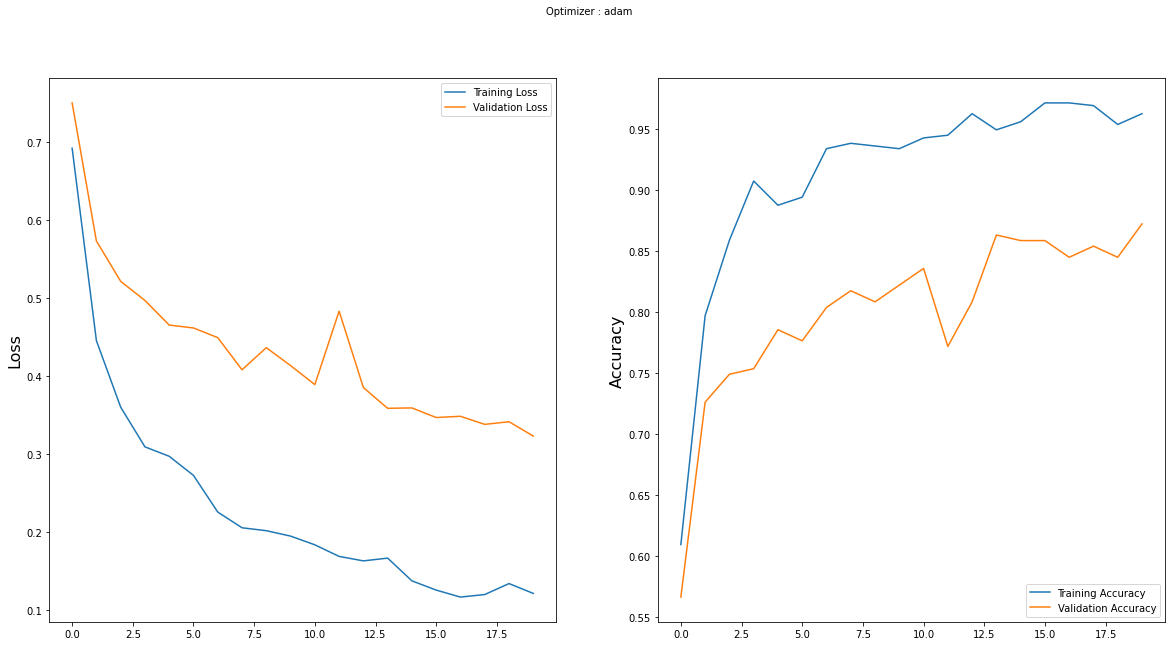

In [ ]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x2 = base_model.output
x2 = GlobalAveragePooling2D()(x2)
'''
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
'''
predictions = Dense(2, activation='softmax')(x2)

# this is the model we will train
models = Model(inputs=base_model.input, outputs=predictions)
models.summary()
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

models.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = models.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[callback])

import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

with rmsprop and default learning rate optimiser

Epoch 1/50
15/15 [==============================] - 18s 1s/step - loss: 0.1939 - accuracy: 0.9338 - val_loss: 0.4193 - val_accuracy: 0.8082
Epoch 2/50
15/15 [==============================] - 16s 1s/step - loss: 0.1411 - accuracy: 0.9558 - val_loss: 0.3894 - val_accuracy: 0.8082
Epoch 3/50
15/15 [==============================] - 16s 1s/step - loss: 0.1208 - accuracy: 0.9647 - val_loss: 0.3190 - val_accuracy: 0.8676
Epoch 4/50
15/15 [==============================] - 17s 1s/step - loss: 0.1515 - accuracy: 0.9338 - val_loss: 0.3881 - val_accuracy: 0.8356
Epoch 5/50
15/15 [==============================] - 17s 1s/step - loss: 0.1521 - accuracy: 0.9492 - val_loss: 0.3180 - val_accuracy: 0.8584
Epoch 6/50
15/15 [==============================] - 16s 1s/step - loss: 0.0960 - accuracy: 0.9713 - val_loss: 0.4448 - val_accuracy: 0.7580
Epoch 7/50
15/15 [==============================] - 16s 1s/step - loss: 0.1413 - accuracy: 0.9382 - val_loss: 0.3034 - val_accuracy: 0.8676
Epoch 8/50
15/15 [==

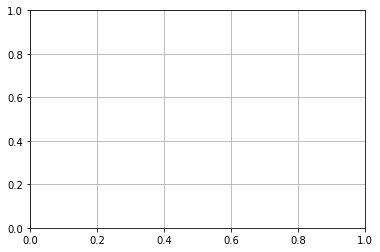

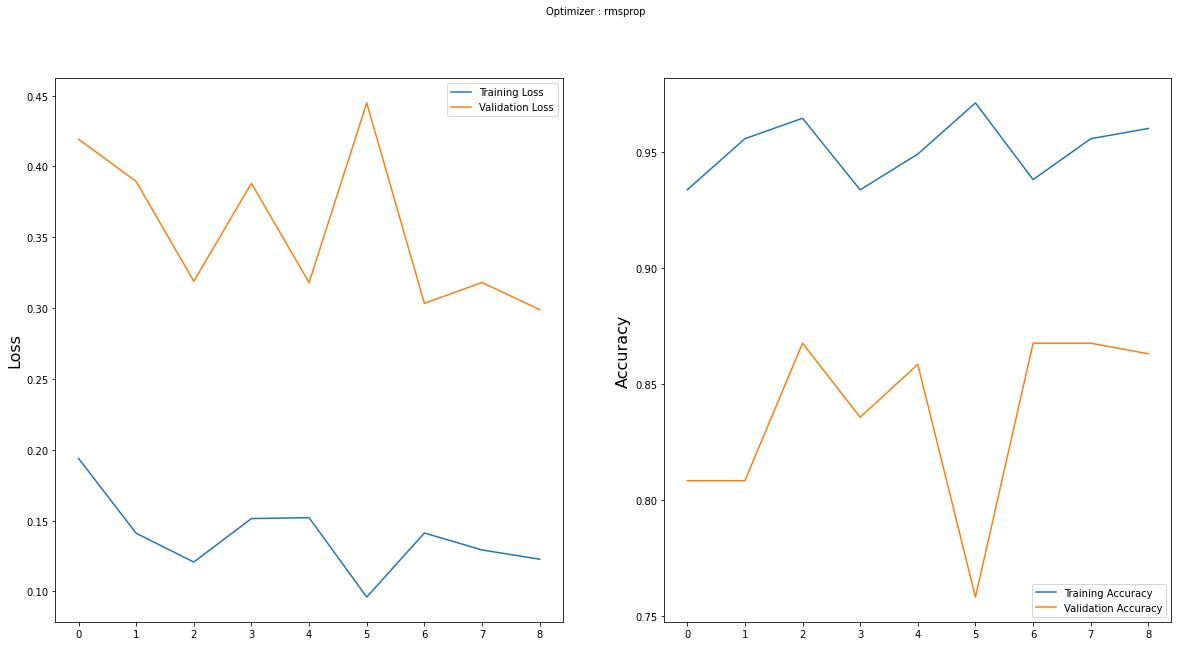

In [ ]:
models.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = models.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[callback])

import matplotlib.pyplot as plt

x=hist
ax = plt.axes()        
ax.yaxis.grid() # horizontal lines
ax.xaxis.grid()
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : rmsprop', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_p=models.predict(test_set,verbose=1,steps=len(test_set))
y_pr=np.argmax(y_p,axis=1)
cm1=confusion_matrix(test_set.classes,y_pr)
total1=sum(sum(cm1))
#from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)
print(classification_report(test_set.classes, y_pr))

7/7 [==============================] - 5s 677ms/step
Accuracy :  0.4885844748858447
Sensitivity :  0.45
Specificity :  0.5210084033613446
              precision    recall  f1-score   support

           0       0.44      0.45      0.45       100
           1       0.53      0.52      0.53       119

    accuracy                           0.49       219
   macro avg       0.49      0.49      0.49       219
weighted avg       0.49      0.49      0.49       219



FOR VGG16

In [ ]:
vgg16=VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 4s 0us/step


In [ ]:
x1= Flatten()(vgg16.output)
prediction1 = Dense(len(folder), activation='softmax')(x1)
model1 = Model(inputs = vgg16.inputs, outputs = prediction1)
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

without callback

In [ ]:
r1 = model1.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
15/15 [==============================] - 18s 1s/step - loss: 10.5864 - accuracy: 0.5232 - val_loss: 0.6767 - val_accuracy: 0.5434
Epoch 2/50
15/15 [==============================] - 17s 1s/step - loss: 0.6823 - accuracy: 0.5806 - val_loss: 0.9396 - val_accuracy: 0.4566
Epoch 3/50
15/15 [==============================] - 18s 1s/step - loss: 0.7198 - accuracy: 0.5298 - val_loss: 0.6776 - val_accuracy: 0.7397
Epoch 4/50
15/15 [==============================] - 17s 1s/step - loss: 0.6690 - accuracy: 0.6203 - val_loss: 0.6740 - val_accuracy: 0.6073
Epoch 5/50
15/15 [==============================] - 17s 1s/step - loss: 0.6345 - accuracy: 0.6976 - val_loss: 0.7777 - val_accuracy: 0.5662
Epoch 6/50
15/15 [==============================] - 17s 1s/step - loss: 0.5363 - accuracy: 0.7660 - val_loss: 0.5529 - val_accuracy: 0.6986
Epoch 7/50
15/15 [==============================] - 17s 1s/step - loss: 0.4561 - accuracy: 0.8278 - val_loss: 0.5668 - val_accuracy: 0.7671
Epoch 8/50
15/15 [=

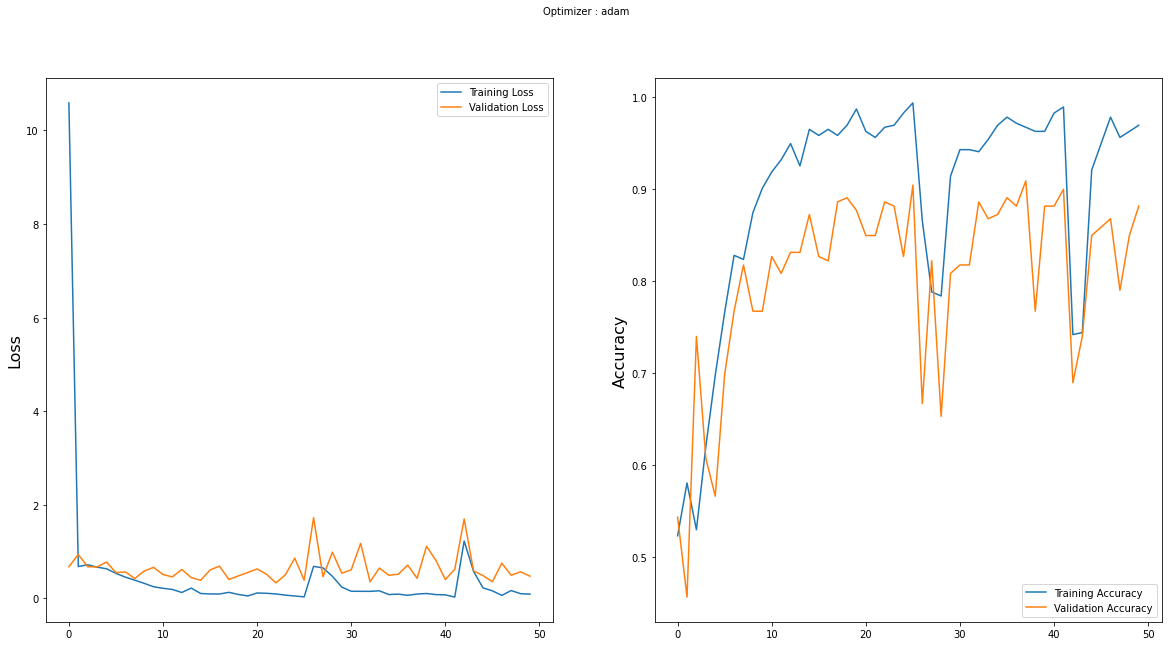

In [ ]:
import matplotlib.pyplot as plt

x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

with callback

Epoch 1/50
15/15 [==============================] - 17s 1s/step - loss: 0.0736 - accuracy: 0.9713 - val_loss: 0.7681 - val_accuracy: 0.8584
Epoch 2/50
15/15 [==============================] - 16s 1s/step - loss: 0.0733 - accuracy: 0.9779 - val_loss: 0.5486 - val_accuracy: 0.8813
Epoch 3/50
15/15 [==============================] - 16s 1s/step - loss: 0.4438 - accuracy: 0.9514 - val_loss: 0.5264 - val_accuracy: 0.8082
Epoch 4/50
15/15 [==============================] - 16s 1s/step - loss: 0.5857 - accuracy: 0.8234 - val_loss: 1.1911 - val_accuracy: 0.6986
Epoch 5/50
15/15 [==============================] - 17s 1s/step - loss: 0.3518 - accuracy: 0.8830 - val_loss: 0.5090 - val_accuracy: 0.7991


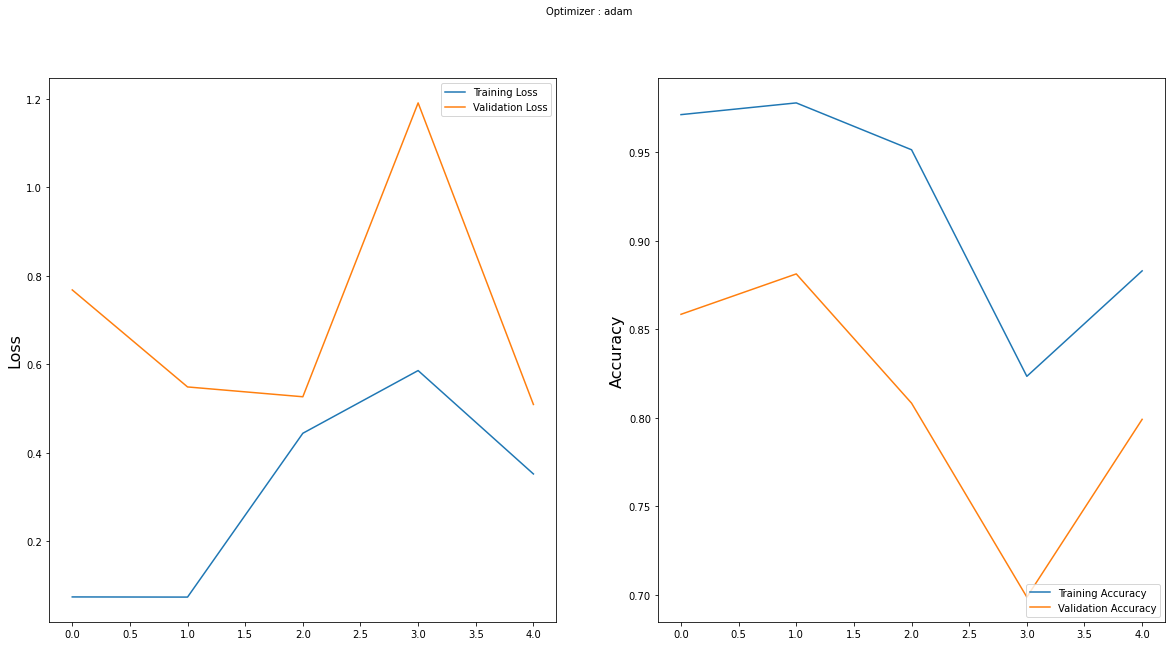

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = model1.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[callback])

import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
vgg19=VGG19(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
x11= Flatten()(vgg19.output)
prediction11 = Dense(len(folder), activation='softmax')(x11)
model11 = Model(inputs = vgg19.inputs, outputs = prediction11)
model11.summary()
model11.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

with callback

Epoch 1/50
15/15 [==============================] - 17s 1s/step - loss: 2.8866 - accuracy: 0.5121 - val_loss: 0.7004 - val_accuracy: 0.5434
Epoch 2/50
15/15 [==============================] - 16s 1s/step - loss: 0.8009 - accuracy: 0.5210 - val_loss: 0.6941 - val_accuracy: 0.4566
Epoch 3/50
15/15 [==============================] - 16s 1s/step - loss: 0.6919 - accuracy: 0.4989 - val_loss: 0.7002 - val_accuracy: 0.4566
Epoch 4/50
15/15 [==============================] - 17s 1s/step - loss: 0.6893 - accuracy: 0.5320 - val_loss: 0.6671 - val_accuracy: 0.7397
Epoch 5/50
15/15 [==============================] - 17s 1s/step - loss: 0.6897 - accuracy: 0.5960 - val_loss: 0.6738 - val_accuracy: 0.5434
Epoch 6/50
15/15 [==============================] - 17s 1s/step - loss: 0.9599 - accuracy: 0.5916 - val_loss: 0.7025 - val_accuracy: 0.5434
Epoch 7/50
15/15 [==============================] - 18s 1s/step - loss: 0.7264 - accuracy: 0.5210 - val_loss: 0.7357 - val_accuracy: 0.4566


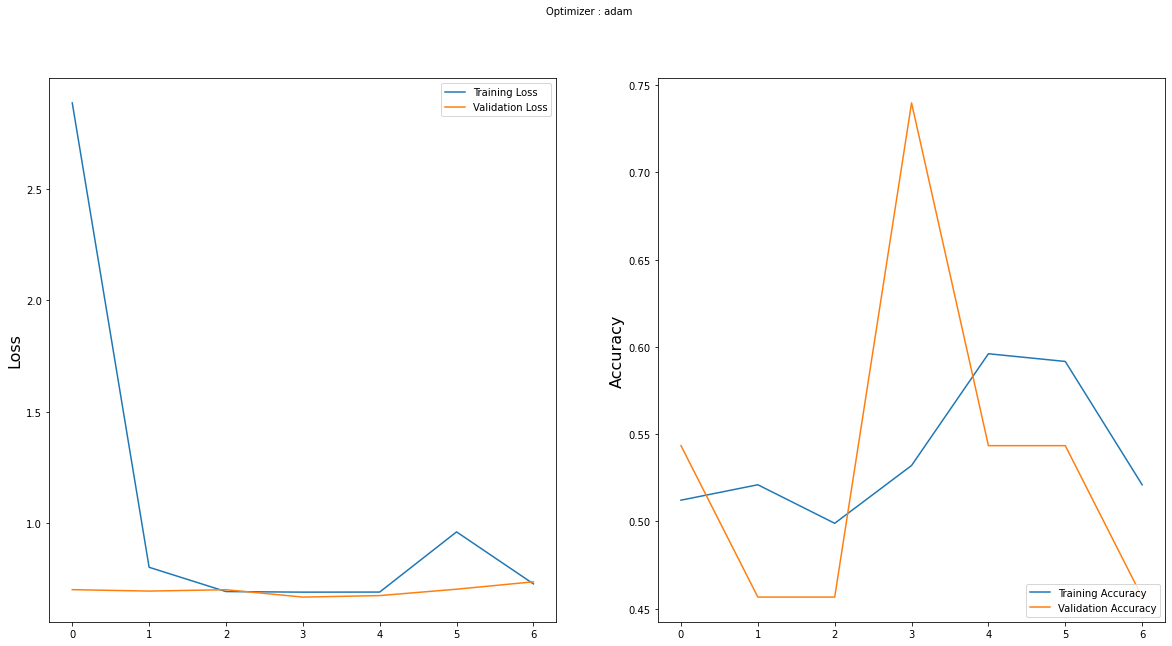

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = model11.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[callback])

import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

INCEPTION RESNET V2

219062272/219055592 [==============================] - 10s 0us/step
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
___________________

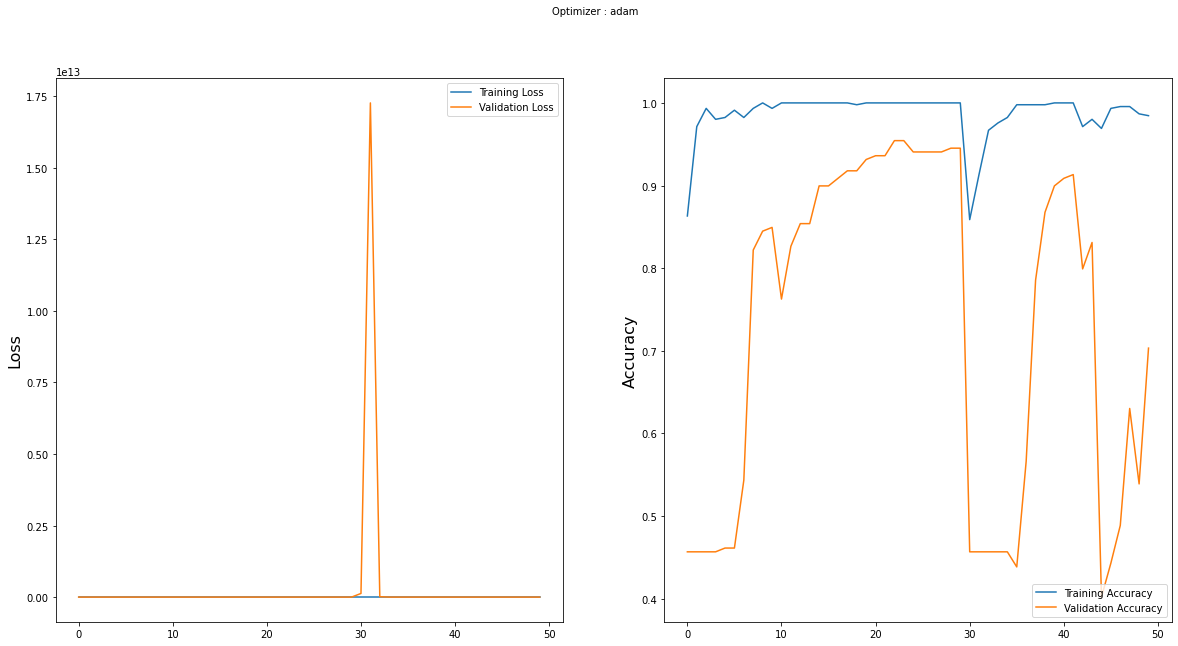

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
inc=InceptionResNetV2(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
x3 = Flatten()(inc.output)
predictionss = Dense(len(folder), activation='softmax')(x3)
modelss = Model(inputs = inc.inputs, outputs = predictionss)
modelss.summary()
modelss.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
r2 = modelss.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))
x=r2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

with callback

Epoch 1/50
15/15 [==============================] - 19s 1s/step - loss: 0.4710 - accuracy: 0.9823 - val_loss: 9.5717 - val_accuracy: 0.6667
Epoch 2/50
15/15 [==============================] - 18s 1s/step - loss: 0.0345 - accuracy: 0.9845 - val_loss: 9.2949 - val_accuracy: 0.7032
Epoch 3/50
15/15 [==============================] - 18s 1s/step - loss: 0.3703 - accuracy: 0.9934 - val_loss: 4.7640 - val_accuracy: 0.7489
Epoch 4/50
15/15 [==============================] - 18s 1s/step - loss: 0.1193 - accuracy: 0.9823 - val_loss: 2.6723 - val_accuracy: 0.8630
Epoch 5/50
15/15 [==============================] - 18s 1s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.6701 - val_accuracy: 0.8858
Epoch 6/50
15/15 [==============================] - 18s 1s/step - loss: 0.5588 - accuracy: 0.9868 - val_loss: 0.4300 - val_accuracy: 0.9406
Epoch 7/50
15/15 [==============================] - 19s 1s/step - loss: 0.3154 - accuracy: 0.9890 - val_loss: 0.4127 - val_accuracy: 0.9178
Epoch 8/50
15/15 [==

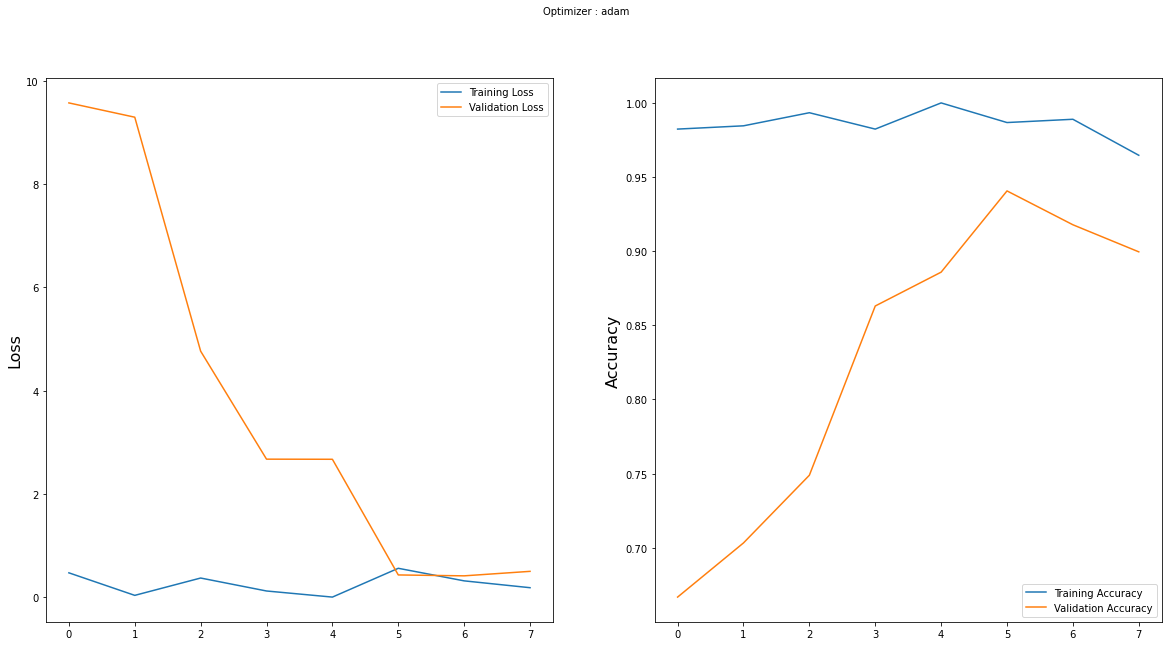

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = modelss.fit_generator(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[callback])

import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

saving the file 

In [ ]:
from tensorflow.keras.models import load_model

model.save('covid_chest_xray_model_transfer_learning.h5')

prediction

In [ ]:
pred = model.predict(test_set)
print(pred)
pred = np.argmax(pred, axis=1)

In [ ]:
model = load_model('covid_chest_xray_model.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
x = image.img_to_array(img)
from tensorflow.keras.applications.resnet50 import preprocess_input

x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

In [ ]:
if(a==1):
    print("Yeah !!! The person is non-COVID-19")
else:
    print("The person is COVID-19 positive.")